### 練習問題2.49
segments->painterを使って、以下の基本ペインタを定義せよ。  

- a. 指定された枠の輪郭を描くペインタ。
- b. 枠の対⾓線同⼠をつないで"X"を描くペインタ。
- c. 枠の辺の中点をつないで菱形を描くペインタ。 
- d. waveペインタ。


In [1]:
; 線形変換
; 通常の行列計算より最適化してある。
; transform-painter手続きで線形変換だけ必要だったので、
; frame-coord-map手続きのアフィン変換と分離した。
(define (linear-transform frame v)
  (let ((edge1 (edge1-frame frame))
        (edge2 (edge2-frame frame)))
    (let ((x (xcor-vect v))
          (y (ycor-vect v)))
      (add-vect (scale-vect x edge1) (scale-vect y edge2))
     )
    )
  )


; テキストの実装から変更している。
; 通常の線形変換の数式に沿っている。
(define (frame-coord-map frame)
  (lambda (v)
    (let ((edge1 (edge1-frame frame))
          (edge2 (edge2-frame frame)))
      (add-vect
       (origin-frame frame)
       (linear-transform frame v)
      )
     )
    )
  )

; ベクトルコンストラクタ・セレクタ
(define (make-vect x y) (cons x y))
(define (xcor-vect v)(car v))
(define (ycor-vect v)(cdr v))

; ベクトル演算
(define (add-vect v1 v2)
  (make-vect (+ (xcor-vect v1)
                (xcor-vect v2))
             (+ (ycor-vect v1)
                (ycor-vect v2))))
(define (sub-vect v1 v2)
  (make-vect (- (xcor-vect v1)
                (xcor-vect v2))
             (- (ycor-vect v1)
                (ycor-vect v2))))
(define (scale-vect s v)
  (make-vect (* s (xcor-vect v))
             (* s (ycor-vect v))))

; フレームコンストラクタ・セレクタ
(define (make-frame origin edge1 edge2)(list origin edge1 edge2))
(define (origin-frame frame)(car frame))
(define (edge1-frame frame)(cadr frame))
(define (edge2-frame frame)(caddr frame))

; 線分コンストラクタ・セレクタ
(define (make-segment v1 v2)(cons v1 v2))
(define (start-segment seg)(car seg))
(define (end-segment seg)(cdr seg))

; ペインタ
(define (segments->painter segment-list)
  (lambda (frame)
    (for-each
     (lambda (segment)
       (draw-line
        ((frame-coord-map frame) (start-segment segment))
        ((frame-coord-map frame) (end-segment segment))))
     segment-list)))

; ペインタ変換と組み合わせ
(define (transform-painter painter origin corner1 corner2)
  (lambda (frame)
    (let ((m (frame-coord-map frame)))
      (let ((new-origin (m origin)))
        (painter
         (make-frame new-origin
                     (linear-transform frame corner1)
                     (linear-transform frame corner2)
                     )
         )
        )
      )
    )
  )


; 線形変換のベクトルは変更
(define (flip-vert painter)
  (transform-painter painter
                     ;(make-vect 0.0 1.0)
                     ;(make-vect 1.0 1.0)
                     ;(make-vect 0.0 0.0)
                     (make-vect 0.0 1.0)
                     (make-vect 1.0 0.0)
                     (make-vect 0.0 -1.0)
    )
  )

; 線形変換のベクトルは変更
(define (beside painter1 painter2)
  (let ((split-point (make-vect 0.5 0.0)))
    (let ((paint-left
           (transform-painter painter1
                              (make-vect 0.0 0.0)
                              split-point
                              (make-vect 0.0 1.0)
                              )
           )
          (paint-right
           (transform-painter painter2
                              ;split-point
                              ;(make-vect 1.0 0.0)
                              ;(make-vect 0.5 1.0)
                              split-point
                              split-point
                              (make-vect 0.0 1.0)
                              )
           )
          )
      (lambda (frame)
        (paint-left frame)
        (paint-right frame)))))

(define (below painter1 painter2)
  (let ((split-point (make-vect 0.0 0.5)))
    (let ((paint-below
           (transform-painter painter1
                              (make-vect 0.0 0.0)
                              (make-vect 1.0 0.0)
                              split-point))
          (paint-above
           (transform-painter painter2
                              split-point
                              (make-vect 1.0 0.0)
                              (make-vect 0.0 0.5))))
      (lambda (frame)
        (paint-below frame)
        (paint-above frame)))))

(import-as "picseg" 'pic)

(define (draw-line v1 v2)
  (let ((start-x (xcor-vect v1))
        (start-y (ycor-vect v1))
        (end-x (xcor-vect v2))
        (end-y (ycor-vect v2)))
    (pic.draw_line start-x start-y end-x end-y)
    ;(display "(")
    ;(display start-x)
    ;(display ",")
    ;(display start-y)
    ;(display ") (")
    ;(display end-x)
    ;(display ",")
    ;(display end-y)
    ;(display ")")
    ;(newline)
    )
  )

; ペインタの動作確認
(define (paint painter)
  (let ((frame0 (make-frame
                            (make-vect 0 0)
                            (make-vect 1 0)
                            (make-vect 0 1))))
    (pic.clear)
    (painter frame0)
    (pic.update)
    )
  )

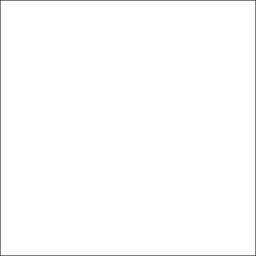

In [2]:
; a.指定された枠の輪郭を描くペインタ。
(define (rect s)
  (lambda (frame)
    ((segments->painter
      (list (make-segment (make-vect 0 0) (make-vect 0 s))
            (make-segment (make-vect 0 s) (make-vect s s))
            (make-segment (make-vect s s) (make-vect s 0))
            (make-segment (make-vect s 0) (make-vect 0 0)))) frame)))

(paint (rect 1))

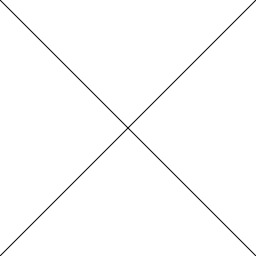

In [3]:
; b.枠の対⾓線同⼠をつないで"X"を描くペインタ。
(define (rect-x s)
  (lambda (frame)
    ((segments->painter
      (list (make-segment (make-vect 0 0) (make-vect s s))
            (make-segment (make-vect 0 s) (make-vect s 0)))) frame)))

(paint (rect-x 1))

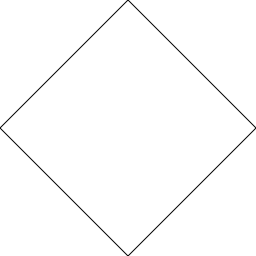

In [4]:
; c.枠の辺の中点をつないで菱形を描くペインタ。
(define (dia s)
  (let ((c (/ s 2)))
    (lambda (frame)
      ((segments->painter
        (list (make-segment (make-vect 0 c) (make-vect c s))
              (make-segment (make-vect c s) (make-vect s c))
              (make-segment (make-vect s c) (make-vect c 0))
              (make-segment (make-vect c 0) (make-vect 0 c)))) frame))
    )
  )

(paint (dia 1))

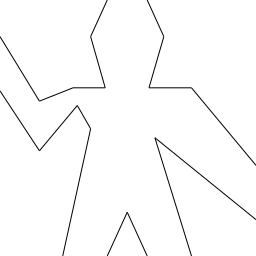

In [5]:
; d.waveペインタ
; 以下のサイトを参照しました。
; https://gist.github.com/tkmr/28498
(define wave
  (lambda (frame)
    ((segments->painter
      (list (make-segment (make-vect 0.000 0.645) (make-vect 0.154 0.411))
            (make-segment (make-vect 0.154 0.411) (make-vect 0.302 0.588))
            (make-segment (make-vect 0.302 0.588) (make-vect 0.354 0.497))
            (make-segment (make-vect 0.354 0.497) (make-vect 0.245 0.000))
            (make-segment (make-vect 0.419 0.000) (make-vect 0.497 0.171))
            (make-segment (make-vect 0.497 0.171) (make-vect 0.575 0.000))
            (make-segment (make-vect 0.748 0.000) (make-vect 0.605 0.462))
            (make-segment (make-vect 0.605 0.462) (make-vect 1.000 0.142))
            (make-segment (make-vect 1.000 0.354) (make-vect 0.748 0.657))
            (make-segment (make-vect 0.748 0.657) (make-vect 0.582 0.657))
            (make-segment (make-vect 0.582 0.657) (make-vect 0.640 0.857))
            (make-segment (make-vect 0.640 0.857) (make-vect 0.575 1.000))
            (make-segment (make-vect 0.419 1.000) (make-vect 0.354 0.857))
            (make-segment (make-vect 0.354 0.857) (make-vect 0.411 0.657))
            (make-segment (make-vect 0.411 0.657) (make-vect 0.285 0.657))
            (make-segment (make-vect 0.285 0.657) (make-vect 0.154 0.605))
            (make-segment (make-vect 0.154 0.605) (make-vect 0.000 0.857)))) frame)))


(paint wave)